In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
num_classes = 7

In [4]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [9]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((280, 218))
])

#dataset_str = 'cropped_images'
#dataset_str = 'cropped_processed_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'
#dataset_str = 'cropped_rotated_processed_images_3'
#dataset_str = 'cropped_rotated_processed_images_4'
#dataset_str = "cropped_rotated_processed_images_5"
dataset_str = "cropped_rotated_processed_images_6"

training_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=0)

testing_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=10, shuffle=True, num_workers=0)

In [10]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [11]:
model = model.to(device)

In [12]:
results_dir = 'results/'

In [13]:
import csv
csv_header = ['Classification loss']

csvfile = open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [14]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                    print(
                        f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                    )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 14 / 20 with accuracy 70.00
Got 22 / 30 with accuracy 73.33
Got 29 / 40 with accuracy 72.50
Got 38 / 50 with accuracy 76.00
Got 45 / 60 with accuracy 75.00
Got 54 / 70 with accuracy 77.14
Got 63 / 80 with accuracy 78.75
Got 71 / 90 with accuracy 78.89
Got 79 / 100 with accuracy 79.00
Got 87 / 110 with accuracy 79.09
Got 97 / 120 with accuracy 80.83
Got 104 / 130 with accuracy 80.00
Got 111 / 140 with accuracy 79.29
Got 118 / 150 with accuracy 78.67
Got 125 / 160 with accuracy 78.12
Got 132 / 170 with accuracy 77.65
Got 141 / 180 with accuracy 78.33
Got 148 / 190 with accuracy 77.89
Got 154 / 196 with accuracy 78.57
----------
Epoch 1/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 11 / 20 with accuracy 55.00
Got 18 / 30 with accuracy 60.00
Got 25 / 40 with accuracy 62.50
Got 32 / 50 with accuracy 64.00
Got 40 / 60 with accuracy 66.67
Got 49 / 70 with accuracy 70.00
Got 55 / 80 with accuracy 68.75
Got 61 / 90 with accuracy 67.78
Got 69 / 100 with accuracy 69.00
Got 77 / 110 with accuracy 70.00
Got 86 / 120 with accuracy 71.67
Got 96 / 130 with accuracy 73.85
Got 105 / 140 with accuracy 75.00
Got 112 / 150 with accuracy 74.67
Got 119 / 160 with accuracy 74.38
Got 128 / 170 with accuracy 75.29
Got 135 / 180 with accuracy 75.00
Got 143 / 190 with accuracy 75.26
Got 149 / 196 with accuracy 76.02
----------
Epoch 2/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 28 / 30 with accuracy 93.33
Got 38 / 40 with accuracy 95.00
Got 47 / 50 with accuracy 94.00
Got 57 / 60 with accuracy 95.00
Got 65 / 70 with accuracy 92.86
Got 74 / 80 with accuracy 92.50
Got 84 / 90 with accuracy 93.33
Got 93 / 100 with accuracy 93.00
Got 102 / 110 with accuracy 92.73
Got 112 / 120 with accuracy 93.33
Got 121 / 130 with accuracy 93.08
Got 130 / 140 with accuracy 92.86
Got 137 / 150 with accuracy 91.33
Got 147 / 160 with accuracy 91.88
Got 157 / 170 with accuracy 92.35
Got 166 / 180 with accuracy 92.22
Got 176 / 190 with accuracy 92.63
Got 181 / 196 with accuracy 92.35
----------
Epoch 3/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 44 / 50 with accuracy 88.00
Got 54 / 60 with accuracy 90.00
Got 63 / 70 with accuracy 90.00
Got 73 / 80 with accuracy 91.25
Got 82 / 90 with accuracy 91.11
Got 91 / 100 with accuracy 91.00
Got 100 / 110 with accuracy 90.91
Got 110 / 120 with accuracy 91.67
Got 119 / 130 with accuracy 91.54
Got 129 / 140 with accuracy 92.14
Got 138 / 150 with accuracy 92.00
Got 147 / 160 with accuracy 91.88
Got 154 / 170 with accuracy 90.59
Got 164 / 180 with accuracy 91.11
Got 173 / 190 with accuracy 91.05
Got 178 / 196 with accuracy 90.82
----------
Epoch 4/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 16 / 20 with accuracy 80.00
Got 24 / 30 with accuracy 80.00
Got 31 / 40 with accuracy 77.50
Got 38 / 50 with accuracy 76.00
Got 47 / 60 with accuracy 78.33
Got 56 / 70 with accuracy 80.00
Got 65 / 80 with accuracy 81.25
Got 74 / 90 with accuracy 82.22
Got 82 / 100 with accuracy 82.00
Got 89 / 110 with accuracy 80.91
Got 96 / 120 with accuracy 80.00
Got 104 / 130 with accuracy 80.00
Got 112 / 140 with accuracy 80.00
Got 119 / 150 with accuracy 79.33
Got 127 / 160 with accuracy 79.38
Got 134 / 170 with accuracy 78.82
Got 143 / 180 with accuracy 79.44
Got 150 / 190 with accuracy 78.95
Got 155 / 196 with accuracy 79.08
----------
Epoch 5/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 27 / 30 with accuracy 90.00
Got 35 / 40 with accuracy 87.50
Got 43 / 50 with accuracy 86.00
Got 51 / 60 with accuracy 85.00
Got 59 / 70 with accuracy 84.29
Got 65 / 80 with accuracy 81.25
Got 74 / 90 with accuracy 82.22
Got 84 / 100 with accuracy 84.00
Got 93 / 110 with accuracy 84.55
Got 100 / 120 with accuracy 83.33
Got 109 / 130 with accuracy 83.85
Got 118 / 140 with accuracy 84.29
Got 127 / 150 with accuracy 84.67
Got 137 / 160 with accuracy 85.62
Got 147 / 170 with accuracy 86.47
Got 156 / 180 with accuracy 86.67
Got 166 / 190 with accuracy 87.37
Got 171 / 196 with accuracy 87.24
----------
Epoch 6/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 13 / 20 with accuracy 65.00
Got 22 / 30 with accuracy 73.33
Got 28 / 40 with accuracy 70.00
Got 37 / 50 with accuracy 74.00
Got 46 / 60 with accuracy 76.67
Got 56 / 70 with accuracy 80.00
Got 65 / 80 with accuracy 81.25
Got 75 / 90 with accuracy 83.33
Got 82 / 100 with accuracy 82.00
Got 88 / 110 with accuracy 80.00
Got 95 / 120 with accuracy 79.17
Got 104 / 130 with accuracy 80.00
Got 112 / 140 with accuracy 80.00
Got 122 / 150 with accuracy 81.33
Got 131 / 160 with accuracy 81.88
Got 141 / 170 with accuracy 82.94
Got 150 / 180 with accuracy 83.33
Got 158 / 190 with accuracy 83.16
Got 163 / 196 with accuracy 83.16
----------
Epoch 7/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 17 / 20 with accuracy 85.00
Got 26 / 30 with accuracy 86.67
Got 34 / 40 with accuracy 85.00
Got 43 / 50 with accuracy 86.00
Got 52 / 60 with accuracy 86.67
Got 61 / 70 with accuracy 87.14
Got 71 / 80 with accuracy 88.75
Got 81 / 90 with accuracy 90.00
Got 90 / 100 with accuracy 90.00
Got 99 / 110 with accuracy 90.00
Got 109 / 120 with accuracy 90.83
Got 118 / 130 with accuracy 90.77
Got 127 / 140 with accuracy 90.71
Got 136 / 150 with accuracy 90.67
Got 146 / 160 with accuracy 91.25
Got 155 / 170 with accuracy 91.18
Got 165 / 180 with accuracy 91.67
Got 174 / 190 with accuracy 91.58
Got 180 / 196 with accuracy 91.84
----------
Epoch 8/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 38 / 40 with accuracy 95.00
Got 45 / 50 with accuracy 90.00
Got 55 / 60 with accuracy 91.67
Got 64 / 70 with accuracy 91.43
Got 72 / 80 with accuracy 90.00
Got 82 / 90 with accuracy 91.11
Got 92 / 100 with accuracy 92.00
Got 101 / 110 with accuracy 91.82
Got 109 / 120 with accuracy 90.83
Got 119 / 130 with accuracy 91.54
Got 129 / 140 with accuracy 92.14
Got 139 / 150 with accuracy 92.67
Got 149 / 160 with accuracy 93.12
Got 159 / 170 with accuracy 93.53
Got 169 / 180 with accuracy 93.89
Got 178 / 190 with accuracy 93.68
Got 183 / 196 with accuracy 93.37
----------
Epoch 9/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 30 / 30 with accuracy 100.00
Got 39 / 40 with accuracy 97.50
Got 46 / 50 with accuracy 92.00
Got 55 / 60 with accuracy 91.67
Got 65 / 70 with accuracy 92.86
Got 74 / 80 with accuracy 92.50
Got 81 / 90 with accuracy 90.00
Got 91 / 100 with accuracy 91.00
Got 101 / 110 with accuracy 91.82
Got 110 / 120 with accuracy 91.67
Got 118 / 130 with accuracy 90.77
Got 127 / 140 with accuracy 90.71
Got 137 / 150 with accuracy 91.33
Got 147 / 160 with accuracy 91.88
Got 157 / 170 with accuracy 92.35
Got 167 / 180 with accuracy 92.78
Got 177 / 190 with accuracy 93.16
Got 182 / 196 with accuracy 92.86
----------
Epoch 10/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 6 / 10 with accuracy 60.00
Got 16 / 20 with accuracy 80.00
Got 23 / 30 with accuracy 76.67
Got 31 / 40 with accuracy 77.50
Got 39 / 50 with accuracy 78.00
Got 49 / 60 with accuracy 81.67
Got 58 / 70 with accuracy 82.86
Got 63 / 80 with accuracy 78.75
Got 73 / 90 with accuracy 81.11
Got 80 / 100 with accuracy 80.00
Got 90 / 110 with accuracy 81.82
Got 98 / 120 with accuracy 81.67
Got 107 / 130 with accuracy 82.31
Got 114 / 140 with accuracy 81.43
Got 123 / 150 with accuracy 82.00
Got 128 / 160 with accuracy 80.00
Got 135 / 170 with accuracy 79.41
Got 142 / 180 with accuracy 78.89
Got 149 / 190 with accuracy 78.42
Got 154 / 196 with accuracy 78.57
----------
Epoch 11/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 15 / 20 with accuracy 75.00
Got 24 / 30 with accuracy 80.00
Got 32 / 40 with accuracy 80.00
Got 40 / 50 with accuracy 80.00
Got 50 / 60 with accuracy 83.33
Got 60 / 70 with accuracy 85.71
Got 70 / 80 with accuracy 87.50
Got 78 / 90 with accuracy 86.67
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 100 / 120 with accuracy 83.33
Got 110 / 130 with accuracy 84.62
Got 118 / 140 with accuracy 84.29
Got 127 / 150 with accuracy 84.67
Got 137 / 160 with accuracy 85.62
Got 146 / 170 with accuracy 85.88
Got 154 / 180 with accuracy 85.56
Got 164 / 190 with accuracy 86.32
Got 169 / 196 with accuracy 86.22
----------
Epoch 12/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 28 / 30 with accuracy 93.33
Got 38 / 40 with accuracy 95.00
Got 46 / 50 with accuracy 92.00
Got 56 / 60 with accuracy 93.33
Got 65 / 70 with accuracy 92.86
Got 74 / 80 with accuracy 92.50
Got 83 / 90 with accuracy 92.22
Got 91 / 100 with accuracy 91.00
Got 100 / 110 with accuracy 90.91
Got 110 / 120 with accuracy 91.67
Got 119 / 130 with accuracy 91.54
Got 128 / 140 with accuracy 91.43
Got 136 / 150 with accuracy 90.67
Got 144 / 160 with accuracy 90.00
Got 154 / 170 with accuracy 90.59
Got 164 / 180 with accuracy 91.11
Got 174 / 190 with accuracy 91.58
Got 180 / 196 with accuracy 91.84
----------
Epoch 13/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 47 / 50 with accuracy 94.00
Got 55 / 60 with accuracy 91.67
Got 65 / 70 with accuracy 92.86
Got 74 / 80 with accuracy 92.50
Got 83 / 90 with accuracy 92.22
Got 92 / 100 with accuracy 92.00
Got 102 / 110 with accuracy 92.73
Got 112 / 120 with accuracy 93.33
Got 122 / 130 with accuracy 93.85
Got 132 / 140 with accuracy 94.29
Got 140 / 150 with accuracy 93.33
Got 150 / 160 with accuracy 93.75
Got 160 / 170 with accuracy 94.12
Got 170 / 180 with accuracy 94.44
Got 179 / 190 with accuracy 94.21
Got 185 / 196 with accuracy 94.39
----------
Epoch 14/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 46 / 50 with accuracy 92.00
Got 56 / 60 with accuracy 93.33
Got 66 / 70 with accuracy 94.29
Got 75 / 80 with accuracy 93.75
Got 84 / 90 with accuracy 93.33
Got 94 / 100 with accuracy 94.00
Got 103 / 110 with accuracy 93.64
Got 113 / 120 with accuracy 94.17
Got 123 / 130 with accuracy 94.62
Got 132 / 140 with accuracy 94.29
Got 142 / 150 with accuracy 94.67
Got 151 / 160 with accuracy 94.38
Got 161 / 170 with accuracy 94.71
Got 171 / 180 with accuracy 95.00
Got 181 / 190 with accuracy 95.26
Got 187 / 196 with accuracy 95.41
----------
Epoch 15/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 27 / 30 with accuracy 90.00
Got 36 / 40 with accuracy 90.00
Got 44 / 50 with accuracy 88.00
Got 54 / 60 with accuracy 90.00
Got 62 / 70 with accuracy 88.57
Got 72 / 80 with accuracy 90.00
Got 80 / 90 with accuracy 88.89
Got 87 / 100 with accuracy 87.00
Got 95 / 110 with accuracy 86.36
Got 103 / 120 with accuracy 85.83
Got 111 / 130 with accuracy 85.38
Got 120 / 140 with accuracy 85.71
Got 127 / 150 with accuracy 84.67
Got 137 / 160 with accuracy 85.62
Got 146 / 170 with accuracy 85.88
Got 155 / 180 with accuracy 86.11
Got 164 / 190 with accuracy 86.32
Got 169 / 196 with accuracy 86.22
----------
Epoch 16/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 18 / 20 with accuracy 90.00
Got 26 / 30 with accuracy 86.67
Got 36 / 40 with accuracy 90.00
Got 45 / 50 with accuracy 90.00
Got 54 / 60 with accuracy 90.00
Got 64 / 70 with accuracy 91.43
Got 73 / 80 with accuracy 91.25
Got 82 / 90 with accuracy 91.11
Got 89 / 100 with accuracy 89.00
Got 97 / 110 with accuracy 88.18
Got 107 / 120 with accuracy 89.17
Got 117 / 130 with accuracy 90.00
Got 126 / 140 with accuracy 90.00
Got 134 / 150 with accuracy 89.33
Got 142 / 160 with accuracy 88.75
Got 151 / 170 with accuracy 88.82
Got 160 / 180 with accuracy 88.89
Got 170 / 190 with accuracy 89.47
Got 176 / 196 with accuracy 89.80
----------
Epoch 17/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 15 / 20 with accuracy 75.00
Got 24 / 30 with accuracy 80.00
Got 32 / 40 with accuracy 80.00
Got 42 / 50 with accuracy 84.00
Got 51 / 60 with accuracy 85.00
Got 60 / 70 with accuracy 85.71
Got 68 / 80 with accuracy 85.00
Got 76 / 90 with accuracy 84.44
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 104 / 120 with accuracy 86.67
Got 113 / 130 with accuracy 86.92
Got 122 / 140 with accuracy 87.14
Got 127 / 150 with accuracy 84.67
Got 135 / 160 with accuracy 84.38
Got 143 / 170 with accuracy 84.12
Got 150 / 180 with accuracy 83.33
Got 157 / 190 with accuracy 82.63
Got 161 / 196 with accuracy 82.14
----------
Epoch 18/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 39 / 40 with accuracy 97.50
Got 48 / 50 with accuracy 96.00
Got 57 / 60 with accuracy 95.00
Got 66 / 70 with accuracy 94.29
Got 74 / 80 with accuracy 92.50
Got 81 / 90 with accuracy 90.00
Got 91 / 100 with accuracy 91.00
Got 101 / 110 with accuracy 91.82
Got 110 / 120 with accuracy 91.67
Got 119 / 130 with accuracy 91.54
Got 129 / 140 with accuracy 92.14
Got 139 / 150 with accuracy 92.67
Got 149 / 160 with accuracy 93.12
Got 157 / 170 with accuracy 92.35
Got 166 / 180 with accuracy 92.22
Got 176 / 190 with accuracy 92.63
Got 181 / 196 with accuracy 92.35
----------
Epoch 19/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 27 / 30 with accuracy 90.00
Got 35 / 40 with accuracy 87.50
Got 44 / 50 with accuracy 88.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 69 / 80 with accuracy 86.25
Got 77 / 90 with accuracy 85.56
Got 83 / 100 with accuracy 83.00
Got 93 / 110 with accuracy 84.55
Got 102 / 120 with accuracy 85.00
Got 108 / 130 with accuracy 83.08
Got 116 / 140 with accuracy 82.86
Got 126 / 150 with accuracy 84.00
Got 135 / 160 with accuracy 84.38
Got 145 / 170 with accuracy 85.29
Got 153 / 180 with accuracy 85.00
Got 163 / 190 with accuracy 85.79
Got 169 / 196 with accuracy 86.22


In [15]:
csvfile.close()

In [16]:
best_acc

95.40816326530613

In [17]:
torch.save(best_model_wts, f'salvataggi_pytorch/{dataset_str}_model_state_dict')

In [18]:
model.load_state_dict(torch.load(f'salvataggi_pytorch/{dataset_str}_model_state_dict'))
model.to(torch.device('cpu'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [19]:
testloader = DataLoader(testing_dataset, shuffle=False, batch_size=32, num_workers=0)
preds = []
y_true = []
for x, y in testloader:
    scores = model(x)
    predictions = scores.argmax(1)
    preds.append(predictions)
    y_true.append(y)

preds = torch.cat(preds)
y_true = torch.cat(y_true)

In [20]:
preds

tensor([3, 0, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6])

In [21]:
y_true

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6])

In [22]:
import pandas as pd

In [23]:
df = pd.DataFrame({'predictions': preds.cpu().numpy(), 'y_true': y_true.cpu().numpy()})
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,3,0
1,0,0
2,3,0
3,5,0
4,0,0
...,...,...
191,6,6
192,6,6
193,6,6
194,6,6


In [24]:
preds = df['predictions'].values
preds

array([3, 0, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
      dtype=int64)

In [25]:
y_true = df['y_true'].values
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
      dtype=int64)

In [26]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [27]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [28]:
results_dict

{'A': [19, 22],
 'B': [33, 33],
 'C': [23, 24],
 'D': [21, 23],
 'E': [30, 31],
 'F': [27, 28],
 'G': [34, 35]}

In [29]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,19,22
B,33,33
C,23,24
D,21,23
E,30,31
F,27,28
G,34,35


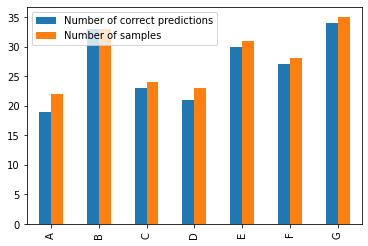

In [30]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [32]:
print(confusion_matrix(y_true, preds))

[[19  0  0  2  0  1  0]
 [ 0 33  0  0  0  0  0]
 [ 0  0 23  0  1  0  0]
 [ 2  0  0 21  0  0  0]
 [ 1  0  0  0 30  0  0]
 [ 0  1  0  0  0 27  0]
 [ 0  1  0  0  0  0 34]]


In [33]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.9540816326530612

In [34]:
with open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [35]:
precision = precision_score(y_true, preds, average=None)
precision

array([0.86363636, 0.94285714, 1.        , 0.91304348, 0.96774194,
       0.96428571, 1.        ])

In [36]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.86363636, 1.        , 0.95833333, 0.91304348, 0.96774194,
       0.96428571, 0.97142857])

In [37]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.86363636, 0.97058824, 0.9787234 , 0.91304348, 0.96774194,
       0.96428571, 0.98550725])

In [38]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,0.863636,0.863636,0.863636
B,0.942857,1.000000,0.970588
C,1.000000,0.958333,0.978723
D,0.913043,0.913043,0.913043
E,0.967742,0.967742,0.967742
F,0.964286,0.964286,0.964286
G,1.000000,0.971429,0.985507


<AxesSubplot:>

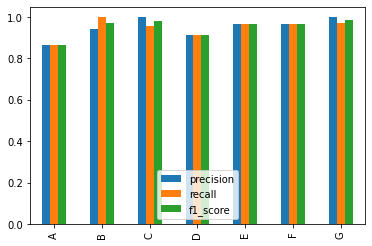

In [39]:
df.plot.bar()